In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm 

#Data Import
df = pd.read_csv('Beach_Water_Quality_Monitoring.csv')

# Research Question and Background

The San Francisco Department of Public Health and DataSF worked together to administer a program that monitors beach water quality in San Francisco. The water is first sampled then brought back to the microbiology lab to perform bacteriological analyses. The data below displays the water source, date of sample retrieval, the analysis, and amount of data collections.

For this project, we will analyze analytes and the source of contamination to determine if there is a relationship between them. For example, would one source (ie. Bay) tend to have a higher chance of having a specific analyte (ie. Entero) than another source?

# Data Cleaning

In [2]:
df

,source,sample_date,analyte,data,uniqueID
0,BAY#211_SL,2020/08/31,COLI_E,74,00139E644FE04108821489A810D0AA9D
1,OCEAN#15_SL,2020/09/01,COLI_TOTAL,5475,012C756E5C2B04D033C90223C81FA39F
2,OCEAN#17_SL,2020/08/31,COLI_E,<10,099D69C8E528B6CA3D6619A4AAB9DAA0
3,OCEAN#21.1_SL,2020/08/31,ENTERO,<10,0CCA828DB4EDEC54F457CF157B8DF458
4,OCEAN#18_SL,2020/08/31,COLI_TOTAL,<10,0F1A34327DD00E3B338832DAF87ACFB0
...,...,...,...,...,...
5630,OCEAN#22_SL,2021/12/14,COLI_TOTAL,620,3F1EDB14920BE7BD676613428D54A08B
5631,OCEAN#22_SL,2021/12/14,ENTERO,98,65AB0E1E9D4A2650EF83AD1416B568C4
5632,OCEAN#22_SL,2021/12/13,COLI_FECAL,195,B9E4FA29BF9BD850F9F03DE45F452233
5633,OCEAN#22_SL,2021/12/13,COLI_TOTAL,1000,16DC20B6DB67285F14E5239E1AFE1050


In [3]:
df['analyte'].unique()
df['source'].unique()

array(['BAY#211_SL', 'OCEAN#15_SL', 'OCEAN#17_SL', 'OCEAN#21.1_SL',
       'OCEAN#18_SL', 'BAY#301.2_SL', 'BAY#300.1_SL', 'OCEAN#16_SL',
       'OCEAN#19_SL', 'BAY#320_SL', 'OCEAN#15EAST_SL', 'BAY#202.5_SL',
       'BAY#202.4_SL', 'BAY#301.1_SL', 'BAY#220_SL', 'BAY#210.1_SL',
       'BAY#230_SL', 'OCEAN#22_SL', 'OCEAN#20_SL', 'OCEAN#21_SL'],
      dtype=object)

In [27]:
df['analyte'].value_counts()

ENTERO        1877
COLI_TOTAL    1873
COLI_FECAL    1033
COLI_E         848
Name: analyte, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5635 entries, 0 to 5634
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source       5635 non-null   object
 1   sample_date  5631 non-null   object
 2   analyte      5631 non-null   object
 3   data         5631 non-null   object
 4   uniqueID     5635 non-null   object
dtypes: object(5)
memory usage: 220.2+ KB


In [5]:
df.sample_date = pd.to_datetime(df.sample_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5635 entries, 0 to 5634
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   source       5635 non-null   object        
 1   sample_date  5631 non-null   datetime64[ns]
 2   analyte      5631 non-null   object        
 3   data         5631 non-null   object        
 4   uniqueID     5635 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 220.2+ KB


In [6]:
df.isna().sum()

source         0
sample_date    4
analyte        4
data           4
uniqueID       0
dtype: int64

In [7]:
#drop null columns
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df

,source,sample_date,analyte,data,uniqueID
0,BAY#211_SL,2020-08-31,COLI_E,74,00139E644FE04108821489A810D0AA9D
1,OCEAN#15_SL,2020-09-01,COLI_TOTAL,5475,012C756E5C2B04D033C90223C81FA39F
2,OCEAN#17_SL,2020-08-31,COLI_E,<10,099D69C8E528B6CA3D6619A4AAB9DAA0
3,OCEAN#21.1_SL,2020-08-31,ENTERO,<10,0CCA828DB4EDEC54F457CF157B8DF458
4,OCEAN#18_SL,2020-08-31,COLI_TOTAL,<10,0F1A34327DD00E3B338832DAF87ACFB0
...,...,...,...,...,...
5626,OCEAN#22_SL,2021-12-14,COLI_TOTAL,620,3F1EDB14920BE7BD676613428D54A08B
5627,OCEAN#22_SL,2021-12-14,ENTERO,98,65AB0E1E9D4A2650EF83AD1416B568C4
5628,OCEAN#22_SL,2021-12-13,COLI_FECAL,195,B9E4FA29BF9BD850F9F03DE45F452233
5629,OCEAN#22_SL,2021-12-13,COLI_TOTAL,1000,16DC20B6DB67285F14E5239E1AFE1050


In [9]:
#make new column, adjust colum positions, remove unique ID column,
df.loc[df['source'].str.contains('BAY'), 'source_2'] = 'Bay'
df.loc[df['source'].str.contains('OCEAN'), 'source_2'] = 'Ocean'
df = df[['source','source_2','sample_date','analyte']]
df

,source,source_2,sample_date,analyte
0,BAY#211_SL,Bay,2020-08-31,COLI_E
1,OCEAN#15_SL,Ocean,2020-09-01,COLI_TOTAL
2,OCEAN#17_SL,Ocean,2020-08-31,COLI_E
3,OCEAN#21.1_SL,Ocean,2020-08-31,ENTERO
4,OCEAN#18_SL,Ocean,2020-08-31,COLI_TOTAL
...,...,...,...,...
5626,OCEAN#22_SL,Ocean,2021-12-14,COLI_TOTAL
5627,OCEAN#22_SL,Ocean,2021-12-14,ENTERO
5628,OCEAN#22_SL,Ocean,2021-12-13,COLI_FECAL
5629,OCEAN#22_SL,Ocean,2021-12-13,COLI_TOTAL


# Data Analysis and EDA

[Text(0.5, 0, 'Source')]

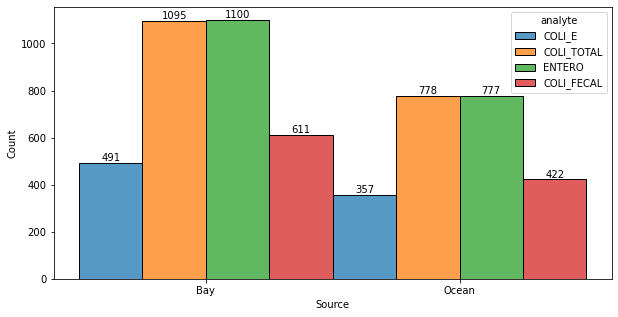

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

graph = sns.histplot(data = df, x = 'source_2', hue = 'analyte', multiple = 'dodge')
for container in graph.containers:
    graph.bar_label(container)

graph.set(xlabel = 'Source')

From this graph, we can see that generally, Bay has the most occurances of analytes from their sampling. This could mean that the Bay has more bacteria than Oceans in their water and that Ocean water quality is better. Though, it is also important to look at this based on proportion because it could just be that they are more often sourcing from Bay than Ocean. 

[Text(0.5, 0, 'Source')]

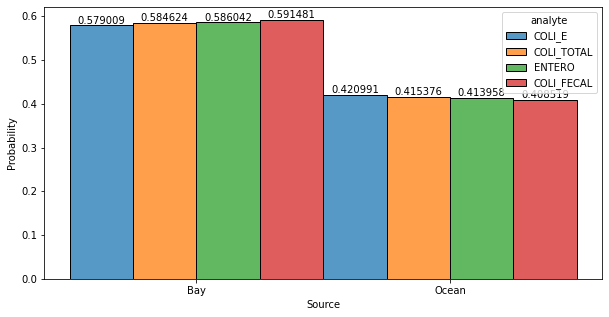

In [11]:
fig, ax = plt.subplots(figsize=(10,5))

graph_2 = sns.histplot(data = df, x = 'source_2', hue = 'analyte', multiple = 'dodge', stat = 'probability', common_norm = False)
for container in graph_2.containers:
    graph_2.bar_label(container)

graph_2.set(xlabel = 'Source')

From this, we again see the trend where the Bay's water has more contaminations than Oceans. We can also see that generally, Bay waters have a higher probability being contaminated than ocean waters. Next we will break down the sources and visualize it

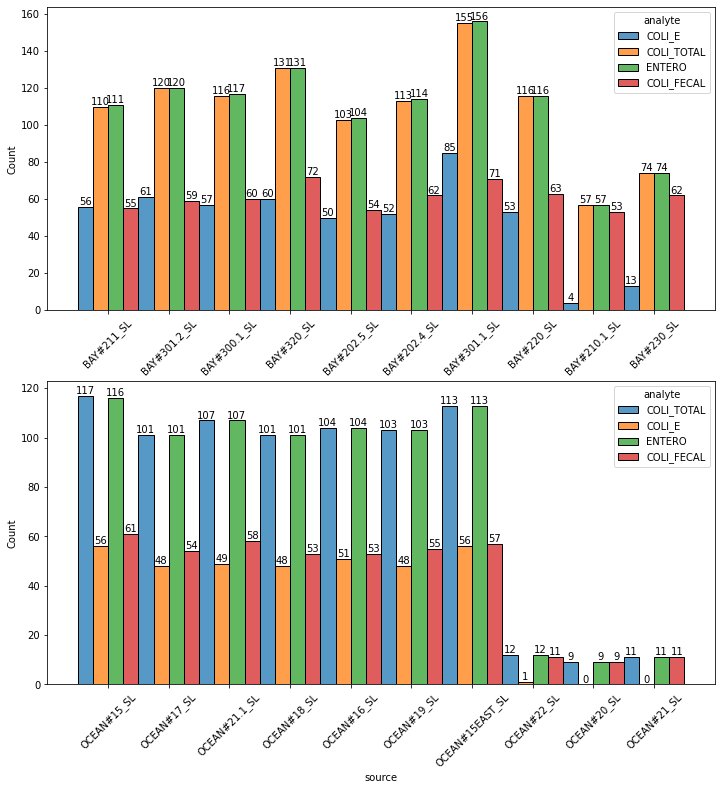

In [12]:
fig, axes = plt.subplots(2,1,figsize=(10,10))
fig.tight_layout(h_pad = 5.0)

bay_df = df[(df['source_2'] == 'Bay')]
ocean_df = df[(df['source_2'] == 'Ocean')]

graph_3 = sns.histplot(data = bay_df, x = 'source', hue = 'analyte', multiple = 'dodge',ax=axes[0])
for container in graph_3.containers:
    graph_3.bar_label(container)

graph_4 = sns.histplot(data = ocean_df, x = 'source', hue = 'analyte', multiple = 'dodge',ax=axes[1])
for container in graph_4.containers:
    graph_4.bar_label(container)
    
axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)

These graphs show that, Bay and Ocean water again has the general trend where they have more contaminations from Entero and Coli_total followed by Coli_fecal and Coli_E throughout samplings.

# Conclusion & Discussion

To conclude, based on the available data, we were able to find a trend where sources of contamination of bacteria most of the time were from Bay water sources rather than Ocean water sources. While further breaking down the data, we found that the majority of bacteria categorized as either Entero or Coli-total. To answer our research question of whether a specific source would have a higher chance of containing a specific analyte than another source, we see that all different types of analyte contaminations have a higher chance of being in Bay waters than Ocean waters. Though, there could be a variety of factors that come into play that have confounding effects. For example, there could generally just be more samplings at the Bay compared to Oceans, which would skew our correlational results towards the Bay. In the future, to future this question, we could further break down the data and look at each source independently.

Summary document that includes:
Your thought process and analysis goals
The analysis goal was to find a water source that would be more likely to contain one analyte than another. For example, I was hoping to find something along the lines of "Bay waters tend to have a higher concentration of Entero whereas Ocean waters tend to have a higher concentration of Coli-E."

Your approach
My approach was to first clean the data and get everything ready, then make data visualizations and see if I could find any relationships between source and analyte columns. Then, I would break down each column and to see specific details.

What worked and what didn’t
I think what worked was the technical part of the project, what didn't work was the results. The results that I received was not what I thought I would receive.

Analysis of statistical significance of your findings
See Conclusion & Discussion

Any assumptions you made
I made an assumption that the samplings of different analytes would be more diverse, which would produce a more cohesive and well-rounded analysis, but in reality, the data was more one-sided
